# 2) KMeans clustering on kaggle dataset

# Datase used is found here: https://www.kaggle.com/arjunbhasin2013/ccdata

# The dataset consists of 9K active credit cardholders over 6 months and their transaction and account attributes. The idea is to develop a customer segmentation for marketing strategy.

# 1. Importing Necessary libraries


In [17]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()


# 2. Reading the dataset


In [18]:
data_customer=spark.read.csv('CC General.csv', header=True, inferSchema=True)


# 3. Printing the schema

In [19]:
 
data_customer.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



# 4. Dropping the null values

In [20]:

data_customer=data_customer.na.drop()

# 5. All attributes under consideration are numerical or discrete numeric, hence we need to convert them into features using a Vector Assembler. 

A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features. Features here are columns. 

Since customer id is an identifier that won’t be used for clustering, we first extract the required columns using .columns, pass it as an input to Vector Assembler, and then use the transform() to convert the input columns into a single vector column called a feature.

In [21]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE'], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)


+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

# 6.Standardize the data
Now that all columns are transformed into a single feature vector we need to standardize the data to bring them to a comparable scale. E.g. Balance can have a scale from 10–1000 whereas balance frequency has a scale from 0–1 say. Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.

In [22]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

# 7. Develop KMeans Algorithm

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score",i,":",score)


Silhouette Score 2 : 0.45688711862867654
Silhouette Score 3 : 0.25964689885263026
Silhouette Score 4 : 0.290830250531179
Silhouette Score 5 : 0.27568627526726064
Silhouette Score 6 : 0.29360506091467087
Silhouette Score 7 : 0.30616006531190926
Silhouette Score 8 : 0.2981844052162474
Silhouette Score 9 : 0.31217647669655013


# We use silhouette score here because
Visualizing the silhouette score. Note previous versions of the K Means had computeScore() that calculated the sum of intracluster distance but got deprecated in Spark 3.0.0. Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is to points in the neighboring clusters thus helping in figuring out clusters that are compact and well-spaced out.

Text(0, 0.5, 'cost')

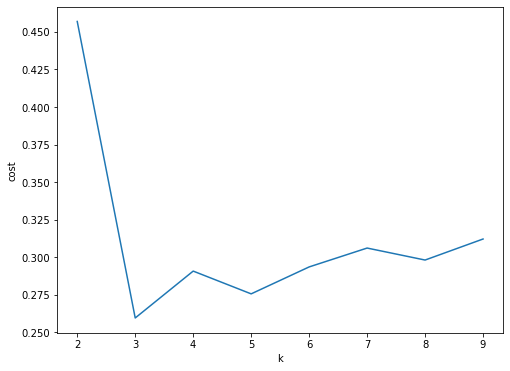

In [24]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

# I prefer going ahead with K=7 as here we can see a local maxima of Silhouette Score is observed.
Look like there is very little gain after k=7

# So now running k means clustering on k=7

In [25]:
k=7

KMeans_algo=KMeans(featuresCol='standardized', k=7)
    
KMeans_fit=KMeans_algo.fit(data_scale_output)
    
output=KMeans_fit.transform(data_scale_output)
    
    
    
score=evaluator.evaluate(output)
    
silhouette_score.append(score)
    
print("Silhouette Score:",score)


Silhouette Score: 0.30616006531190926


In [27]:
k=7
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(assembled_data)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.49325408e+03 9.03824435e-01 1.10778207e+03 6.43803403e+02
 4.64177361e+02 6.89182803e+02 5.69349424e-01 3.03048217e-01
 3.92418375e-01 1.06004854e-01 2.34130019e+00 1.73288719e+01
 7.14593038e+03 1.65675214e+03 5.58727334e+02 1.97572008e-01
 1.17576482e+01]
[8.33875315e+02 8.74414346e-01 5.24345122e+02 2.56436540e+02
 2.68209344e+02 5.08588353e+02 4.56263291e-01 1.34053268e-01
 3.50024647e-01 1.13357007e-01 2.38422053e+00 9.78688213e+00
 2.20143293e+03 9.56227659e+02 5.51617214e+02 1.52750924e-01
 1.14028517e+01]
[5.44820172e+03 9.56126478e-01 2.79165557e+04 2.23543143e+04
 5.56224130e+03 9.70110470e+02 9.05072435e-01 8.50000043e-01
 7.08695609e-01 3.98550435e-02 1.78260870e+00 1.28217391e+02
 1.60434783e+04 2.77616004e+04 3.34571825e+03 5.15316174e-01
 1.19130435e+01]
[2.64027679e+03 9.66987829e-01 6.37930046e+03 4.25491168e+03
 2.12601921e+03 5.72819535e+02 9.09379125e-01 6.98036076e-01
 7.08769783e-01 7.42506277e-02 1.92391304e+00 7.21847826e+01
 9.41277174e+03 